In [1]:
# import necessary libraries
import os, sys, glob
import math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm.auto import tqdm
from PIL import Image
from importlib import reload # when you make changes to a .py, force reload imports


# custom imports
sys.path.append('../')

In [3]:

# learning rate schedule options
warmup_iters = 10000 # number of iterations to reach max learning rate
lr_decay_iters = 90000 # number of iterations to reach min learning rate
max_lr = 1e-3
min_lr = 1e-5
max_iters = 150000 # total number of iterations to train

# gradient clipping options
clip_value = 1

# log options
log_interval = 1 # iterations between logging batch statistics
eval_interval = 1000 # checkpointing interval
log_path = '../logs/log.csv'
chckpnt_path = '../checkpoints/checkpoint_{0}.pt'
iter_update = 'step {0}: train loss {1:.4e}, val loss {2:.4e}\r'

# more options
best_val_loss = None # initialize best validation loss
early_stop = 50 # set value for early stopping counter
last_improved = 0 # start early stopping counter
iter_num = 0 # initialize iteration counter
n_workers = 0 # number of workers for dataloader

# learning rate decay scheduler (cosine with warmup) -- Thanks Andrej Karpathy
def get_lr(it):
    # 1) linear warmup for warmup_iters steps
    if it < warmup_iters:
        return max_lr * it / warmup_iters
    
    # 2) if it > lr_decay_iters, return min learning rate
    
    if it > lr_decay_iters + warmup_iters:
        return min_lr
    
    # 3) in between, use cosine decay down to min learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
    return min_lr + coeff * (max_lr - min_lr)


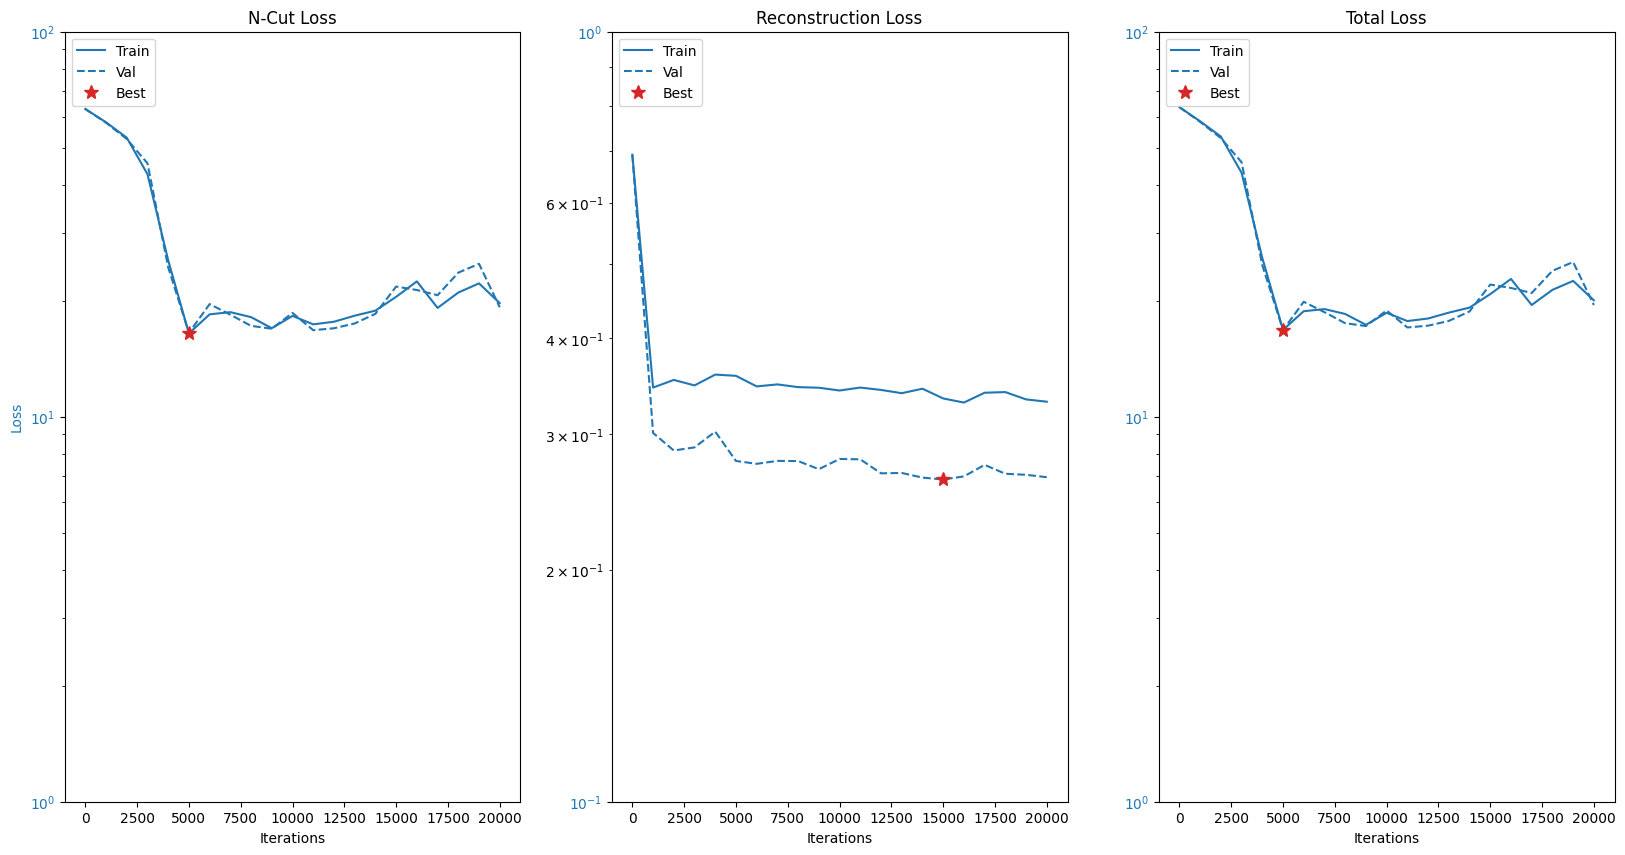

In [6]:
# parse logs
logs = []
with open('../logs/log.csv', 'r') as f:
    logs = f.readlines()
    logs = [l.strip() for l in logs][1:]
logs = [l.split(',') for l in logs]
logs = np.array(logs).astype(float)

iterations, train_n_cut, train_reconstruction, train_loss, val_n_cut, val_reconstruction, val_loss = logs.T
iterations = iterations.astype(int)

iters = np.arange(0, iterations.max(), 100)
lrs = [get_lr(it) for it in iters]

# get best model
best_ncut_iter = iterations[np.argmin(val_n_cut)]
# best_o_iter = iterations[np.argmin(val_o)]
best_rec_iter = iterations[np.argmin(val_reconstruction)]
best_iter = iterations[np.argmin(val_loss)]

# plot
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# n_cut
ax[0].semilogy(iterations, train_n_cut, '-', color='tab:blue', label='Train')
ax[0].semilogy(iterations, val_n_cut, '--', color='tab:blue', label='Val')
ax[0].semilogy(best_ncut_iter, min(val_n_cut), '*', color='tab:red', label='Best', markersize=10)
ax[0].set_ylabel('Loss', color='tab:blue')
ax[0].set_xlabel('Iterations')
ymin, ymax = ax[0].get_ylim()
ymin = 10 ** int(np.log10(ymin) - 1)
ymax = 10 ** int(np.log10(ymax) + 1)
ax[0].set_ylim(ymin, ymax)
ax[0].tick_params(axis='y', labelcolor='tab:blue')
ax[0].legend(loc='upper left')
ax[0].set_title('N-Cut Loss')

# # opening
# ax[1].semilogy(iterations, train_o, '-', color='tab:blue', label='Train')
# ax[1].semilogy(iterations, val_o, '--', color='tab:blue', label='Val')
# ax[1].semilogy(best_o_iter, min(val_o), '*', color='tab:red', label='Best', markersize=10)
# ax[1].set_ylabel('Loss', color='tab:blue')
# ax[1].set_xlabel('Iterations')
# ymin, ymax = ax[1].get_ylim()
# ymin = 10 ** int(np.log10(ymin) - 1)
# ymax = 10 ** int(np.log10(ymax) + 1)
# ax[1].set_ylim(ymin, ymax)
# ax[1].tick_params(axis='y', labelcolor='tab:blue')
# ax[1].legend(loc='upper left')
# ax[1].set_title('Opening Loss')

# rec
ax[1].semilogy(iterations, train_reconstruction, '-', color='tab:blue', label='Train')
ax[1].semilogy(iterations, val_reconstruction, '--', color='tab:blue', label='Val')
ax[1].semilogy(best_rec_iter, min(val_reconstruction), '*', color='tab:red', label='Best', markersize=10)
ax[1].set_xlabel('Iterations')
ymin, ymax = ax[1].get_ylim()
ymin = 10 ** int(np.log10(ymin) - 1)
ymax = 10 ** int(np.log10(ymax) + 1)
ax[1].set_ylim(ymin, ymax)
ax[1].tick_params(axis='y', labelcolor='tab:blue')
ax[1].legend(loc='upper left')
ax[1].set_title('Reconstruction Loss')

# total
ax[2].semilogy(iterations, train_loss, '-', color='tab:blue', label='Train')
ax[2].semilogy(iterations, val_loss, '--', color='tab:blue', label='Val')
ax[2].semilogy(best_iter, min(val_loss), '*', color='tab:red', label='Best', markersize=10)
ax[2].set_xlabel('Iterations')
ymin, ymax = ax[2].get_ylim()
ymin = 10 ** int(np.log10(ymin) - 1)
ymax = 10 ** int(np.log10(ymax) + 1)
ax[2].set_ylim(ymin, ymax)
ax[2].tick_params(axis='y', labelcolor='tab:blue')
ax[2].legend(loc='upper left')
ax[2].set_title('Total Loss')

plt.show()